*CAVEAT: Sorry but just note this notebook can be a bit slow to load probably due to the Plotly embeddings displaying a large number of points*

#Introduction

There already exists a plethora of notebooks discussing the merits of dimensionality reduction methods, in particular the Big 3 of PCA (Principal Component Analysis), LDA ( Linear Discriminant Analysis) and TSNE ( T-Distributed Stochastic Neighbour Embedding). Quite a handful of these have compared one to the other but few have gathered all 3 in one go. Therefore this notebook will aim to provide an introductory exposition on these 3 methods as well as to portray their visualisations interactively and hopefully more intuitively via the Plotly visualisation library. The chapters are structuredas follows:

 1. **Principal Component Analysis ( PCA )**  - Unsupervised, linear method


 2. **Linear Discriminant Analysis (LDA)** - Supervised, linear method


 3. **t-distributed Stochastic Neighbour Embedding (t-SNE)** - Nonlinear, probabilistic method

Lets go.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.offline as py
import plotly.subplots
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

**Curse of Dimensionality & Dimensionality Reduction**

The term "Curse of Dimensionality" has been oft been thrown about, especially when PCA, LDA and TSNE is thrown into the mix. This phrase refers to how our perfectly good and reliable Machine Learning methods may suddenly perform badly when we are dealing in a very high-dimensional space. But what exactly do all these 3 acronyms do? They are essentially transformation methods used for dimensionality reduction. Therefore, if we are able to project our data from a higher-dimensional space to a lower one while keeping most of the relevant information, that would make life a lot easier for our learning methods.

# MNIST Dataset

For the purposes of this interactive guide, the MNIST (Mixed National Institute of Standards and Technology) computer vision digit dataset was chosen partly due to its simplicity and also surprisingly deep and informative research that can be done with the dataset. So let's load the training data and see what we have

In [3]:
train = pd.read_csv('./train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train.shape)

(42000, 785)


The MNIST set consists of 42,000 rows and 785 columns. There are 28 x 28 pixel images of digits  ( contributing to 784 columns) as well as one extra label column which is essentially a class label to state whether the row-wise contribution to each digit gives a 1 or a 9. Each row component contains a value between one and zero and this describes the intensity of each pixel. 

**Pearson Correlation Plot**

Since we are still having the problem that our dataset consists of a relatively large number of features (columns),  it is perfect time to introduce Dimensionality Reduction methods. Before we start off, let's conduct some cleaning of the train data by saving the label feature and then removing it from the dataframe

In [5]:
# save the labels to a Pandas series target
target = train['label']
# Drop the label feature
train = train.drop("label",axis=1)

# 1. Principal Component Analysis (PCA)

In a nutshell, PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information. To do this the algorithm tries to find the most appropriate directions/angles ( which are the principal components ) that maximise the variance in the new subspace. Why maximise the variance though? 

To answer the question, more context has to be given about the PCA method. One has to understand that the principal components are orthogonal to each other ( think right angle ). As such when generating the covariance matrix ( measure of how related 2 variables are to each other ) in our new subspace, the off-diagonal values of the covariance matrix will be zero and only the diagonals ( or eigenvalues) will be non-zero. It is these diagonal values that represent the *variances* of the principal components that we are talking about or information about the variability of our features. 

Therefore when PCA seeks to maximise this variance, the method is trying to find directions ( principal components ) that contain the largest spread/subset of data points or information ( variance ) relative to all the data points present. For a brilliant and detailed description on this, check out this stackexchange thread: 

[PCA and proportion of variance explained][1] by amoeba

  [1]: http://stats.stackexchange.com/a/140579/3277

### Calculating the Eigenvectors

Now it may be informative to observe how the variances look like for the digits in the MNIST dataset. Therefore to achieve this, let us calculate the eigenvectors and eigenvalues of the covarience matrix as follows:

In [6]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = train.values
X_std = StandardScaler().fit_transform(X)

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

Now having calculated both our Individual Explained Variance and Cumulative Explained Variance values, let's use the Plotly visualisation package to produce an interactive chart to showcase this.

In [14]:
trace1 = go.Scatter(
    x=list(range(784)),
    y= cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
#     hoverinfo= cum_var_exp,
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(784)),
    y= var_exp,
    mode='lines+markers',
    name="'Individual Explained Variance'",
#     hoverinfo= var_exp,
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = plotly.subplots.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.5}],
                          print_grid=True)

# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2,1,1)
# fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
# fig.layout.xaxis = dict(range=[0, 80], title = 'Feature columns')
# fig.layout.yaxis = dict(range=[0, 60], title = 'Explained Variance')
# fig['data'] = []
# fig['data'].append(go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance'))
# fig['data'].append(go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance'))

# fig['data'] = go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance')
# fig['data'] += [go.Scatter(x=list(range(784)), y=var_exp, xaxis='x2', yaxis='y2',name = 'Individual Explained Variance')]

# # fig['data'] = data
# # fig['layout'] = layout
# # fig['data'] += data2
# # fig['layout'] += layout2
# py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



*PLEASE CLICK AND MOVE THE SCATTER PLOTS ABOVE. THEY ARE INTERACTIVE. DOUBLE CLICK TO GET BACK TO THE ORIGINAL VIEW*

**Takeaway from the Plot**

There are two plots above, a smaller one embedded within the larger plot. The smaller plot ( Green and Red) shows the distribution of the Individual and Explained variances across all features while the larger plot ( Golden and black ) portrays a zoomed section of the explained variances only.

As we can see, out of our 784 features or columns approximately 90% of the Explained Variance can be described by using just over 200 over features. So if one wanted to implement a PCA on this, extracting the top 200 features would be a very logical choice as they already account for the majority of the data.
In the section below, I will use the immensely powerful Sklearn toolkit and its built-in PCA method. Unfortunately for brevity I will not be covering how to implement PCA from scratch, partly due to the multitude of resources already available. One excellent article to check out for this would be:

[Principal Component Analysis in 3 Simple Steps][1] by Sebastian Raschka 

  [1]: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

**Visualizing the Eigenvalues**

As alluded to above, since the PCA method seeks to obtain the optimal directions (or eigenvectors) that captures the most variance ( spreads out the data points the most ). Therefore it may be informative ( and cool) to visualise these directions and their associated eigenvalues. For the purposes of this notebook and for speed, I will invoke PCA to only extract the top 30 eigenvalues ( using Sklearn's .components_ call) from the digit dataset and visually compare the top 5 eigenvalues to some of the other smaller ones to see if we can glean any insights as follows:

In [15]:
# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(train.values)

eigenvalues = pca.components_.reshape(n_components, 28, 28)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

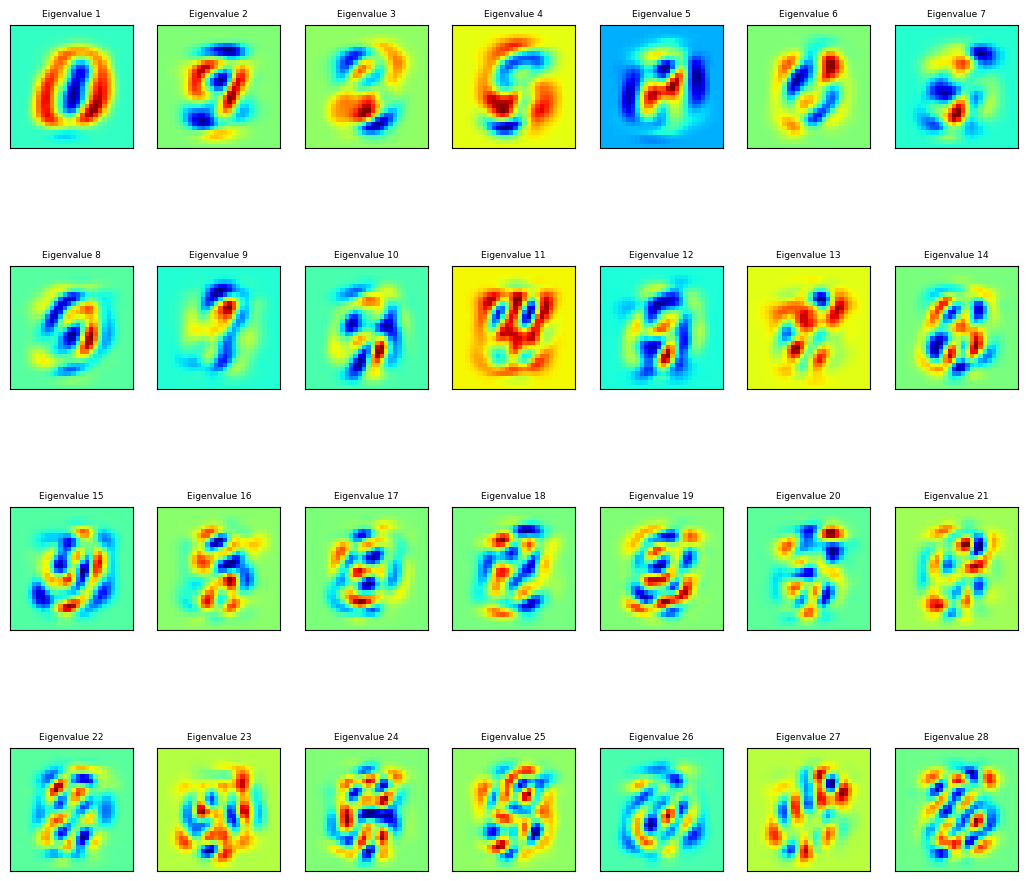

In [16]:
n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

**Takeaway from the Plots**

The subplots above portray the top 30 optimal directions or principal component axes that the PCA method has decided to generate for our digit dataset. Of interest is when one compares the first component "Eigenvalue 1" to the 28th component "Eigenvalue 28", it is obvious that more complicated directions or components are being generated in the search to maximise variance in the new feature subspace.

**Visualising the MNIST Digit set on its own**

Now just for the fun and curiosity of it, let's plot the actual MNIST digit set to see what the underlying dataset actually represents, rather than being caught up with just looking at 1 and 0's.

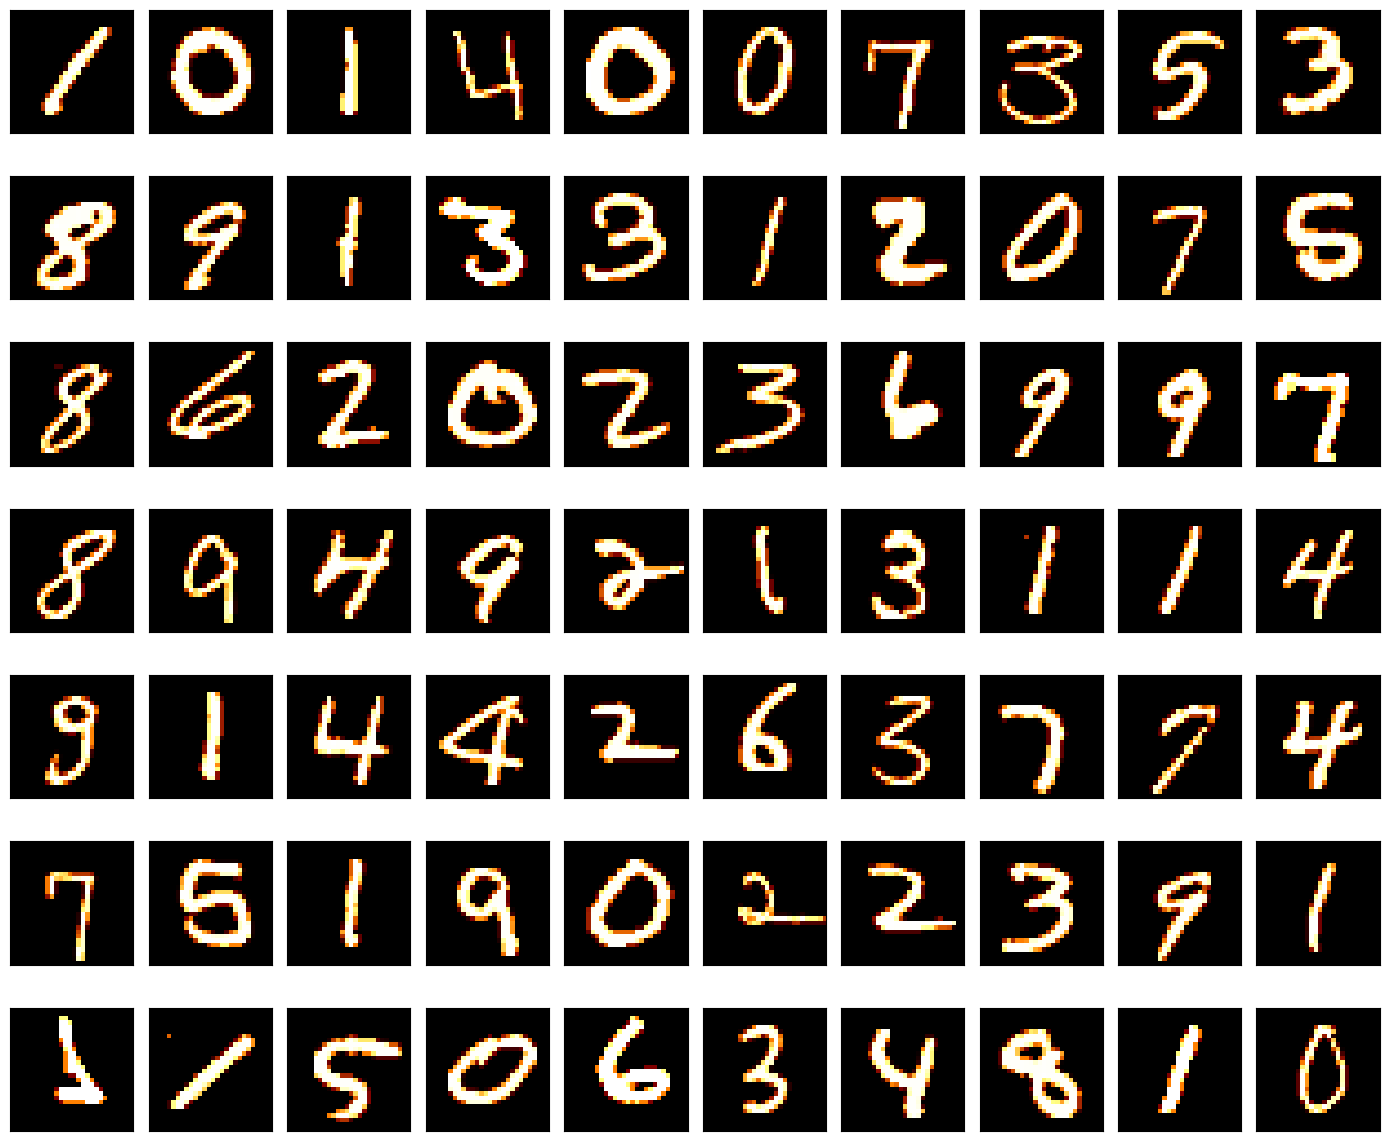

In [18]:
# plot some of the numbers
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = train.iloc[digit_num].values.reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


Phew, they are definitely digits all right. So let's proceed onto the main event.

###PCA Implementation via Sklearn

Now using the Sklearn toolkit, we implement the Principal Component Analysis algorithm as follows:

In [19]:
# Delete our earlier created X object
del X
# Taking only the first N rows to speed things up
X= train[:6000].values
del train
# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with 5 components. 
pca = PCA(n_components=5)
pca.fit(X_std)
X_5d = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = target[:6000]

What the chunk of code does above is to first normalise the data (actually no need to do so for this data set as they are all 1's and 0's) using Sklearn's convenient StandardScaler call.

Next we invoke Sklearn's inbuilt PCA function by providing into its argument *n_components*, the number of components/dimensions we would like to project the data onto. In practise, one would educate and motivate the choice of components for example by looking at the proportion of variance captured vs each feature's eigenvalue, such as in our Explained Variance plots. To be honest, there are a multitude of papers in the literature with research on what should be a good indicator on choice of components. Here are some references for the interested: However for the essence of this notebook being a guide of sorts, I have just decided to take a PCA on 5 components ( against perhaps taking 200 over components).

Finally I call both fit and transform methods which fits the PCA model with the standardised digit data set and then does a transformation by applying the dimensionality reduction on the data.

###Interactive visualisations of PCA representation

When it comes to these dimensionality reduction methods, scatter plots are most commonly implemented because they allow for great and convenient visualisations of clustering ( if any existed ) and this will be exactly what we will be doing as we plot the first 2 principal components as follows:

In [20]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

*PLEASE CLICK AND MOVE THE SCATTER PLOTS ABOVE. THEY ARE INTERACTIVE. DOUBLE CLICK TO GET BACK TO THE ORIGINAL VIEW*

**Takeaway from the Plot**

As observed from the scatter plot, you can just about make out a few discernible clusters evinced from the collective blotches of colors. These clusters represent the underlying digit that each data point should contribute to and one may therefore be tempted to think that it was quite a piece of cake in implementing and visualising PCA in this section.

However, the devil lies in the tiny details of the python implementation because as alluded to earlier, PCA is actually in fact an unsupervised method which does not depend on class labels. I have sneakily snuck in class labelings whilst generating the scatter plots therefore resulting in the clusters of colours as you see them.

###K-Means Clustering to identify possible classes

Imagine just for a moment that we were not provided with the class labels to this digit set because after all PCA is an unsupervised method. Therefore how would we be able to separate out our data points in the new feature space? We can apply a clustering algorithm on our new PCA projection data and hopefully arrive at distinct clusters which would tell us something about the underlying class separation in the data. 

To start off, we set up a KMeans clustering method with Sklearn's *KMeans* call and use the *fit_predict* method to compute cluster centers and predict cluster indices for the first and second PCA projections (to see if we can observe any appreciable clusters).

In [21]:
from sklearn.cluster import KMeans # KMeans clustering 
# Set a KMeans clustering with 9 components ( 9 chosen sneakily ;) as hopefully we get back our 9 class labels)
kmeans = KMeans(n_clusters=9)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_5d)

trace_Kmeans = go.Scatter(x=X_5d[:, 0], y= X_5d[:, 1], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")

c:\Users\amitv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



**Takeaway from the Plot**

Visually, the clusters generated by the KMeans algorithm appear to provide a clearer demarcation amongst clusters as compared to naively adding in class labels into our PCA projections. This should come as no surprise as PCA is meant to be an unsupervised method and therefore not optimised for separating different class labels. This particular task however is accomplished by the very next method that we will talk about.

# 2. Linear Discriminant Analysis (LDA)

LDA, much like PCA is also a linear transformation method commonly used in dimensionality reduction tasks. However unlike the latter which is an unsupervised learning algorithm, LDA falls into the class of supervised learning methods. As such the goal of LDA is that with available information about class labels, LDA will seek to maximise the separation between the different classes by computing the component axes (linear discriminants ) which does this.

In [22]:
from IPython.display import display, Math, Latex

### LDA Implementation from Scratch

The objective of LDA is to preserve the class separation information whilst still  reducing the dimensions of the dataset. As such implementing the method from scratch can roughly be split into 4 distinct stages as below. As an aside, since this section will be quite equation heavy therefore we will also be embedding some mathematical equations into the upcoming sections. The good thing about IPython notebook is that you can render your equations (LaTeX) automatically by putting them within the **$$** symbol, courtesy of the use of MathJax - a JavaScript equation display engine.

**A. Projected Means**

Since this method was designed to take into account class labels we therefore first need to establish a suitable metric with which to measure the 'distance' or separation between different classes. Let's assume that we have a set of data points *x* that belong to one particular class *w*. Therefore in LDA the first step is to the project these points onto a new line, Y that contains the class-specific information via the transformation  

$$Y = \omega^\intercal x $$

With this the idea is to find some method that maximises the separation of these new projected variables. To do so, we first calculate the projected mean.

**B.  Scatter Matrices and their solutions**
Having introduced our projected means, we now need to find a function that can represent the difference between the means and then maximise it. Like in linear regression, where the most basic case is to find the line of best fit we need to find the equivalent of the variance in this context. And hence this is where we introduce scatter matrices where the scatter is the equivalent of the variance.

$$ \tilde{S}^{2} = (y - \tilde{mu})^{2}$$


**C.  Selecting Optimal Projection Matrices**

**D.  Transforming features onto new subspace**

*SECTION STILL UNDER-WAY*

###LDA Implementation via Sklearn

Having gone through the nitty-gritty details of the LDA implementation in theory, let us now implement the method in practise. Surprise, surprise we find that the Sklearn toolkit also comes with its own inbuilt LDA function and hence we invoke an LDA model as follows:

In [23]:
lda = LDA(n_components=5)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(X_std, Target.values )

The syntax for the LDA implementation is very much akin to that of PCA whereby one calls the fit and transform methods which fits the LDA model with the data and then does a transformation by applying the LDA dimensionality reduction to it. However since LDA is a supervised learning algorithm , there is a second argument to the method that the user must provide and this would be the class labels, which in this case is the target labels of the digits.

###Interactive visualisations of LDA representation

In [24]:
8# Using the Plotly library again
traceLDA = go.Scatter(
    x = X_LDA_2D[:,0],
    y = X_LDA_2D[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceLDA]

layout = go.Layout(
    title= 'Linear Discriminant Analysis (LDA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Linear Discriminant',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Linear Discriminant',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

*PLEASE CLICK AND MOVE THE SCATTER PLOTS ABOVE. THEY ARE INTERACTIVE. DOUBLE CLICK TO GET BACK TO THE ORIGINAL VIEW*

From the scatter plot above, we can see that the data points are more clearly clustered when using LDA with as compared to implementing PCA with class labels. This is an inherent advantage in having class labels to supervise the method with. In short picking the right tool for the right job.

#3. T-SNE ( t-Distributed Stochastic Neighbour Embedding )

The t-SNE method has become widely popular ever since it was introduced by van der Maaten and Hinton in 2008. Unlike the previous two linear methods of PCA and LDA discussed above, t-SNE is a non-linear, probabilistic dimensionality reduction method.

The internal mechanisms of the algorithm 
Therefore instead of looking at directions/axes which maximise information or class separation, T-SNE aims to convert the Euclidean distances between points into conditional probabilities. A Student-t distribution is then applied on these probabilities which serve as metrics to calculate the similarity between one datapoint to another. 

However this brief summary does no justice in any manner or shape to the original t-SNE paper by Maaten and Hinton so please do check the original out [here][1].

  [1]: http://www.cs.toronto.edu/~hinton/absps/tsne.pdf

In [25]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_std) 

Having invoked the t-SNE algorithm by simply calling *TSNE()* we fit the digit data to the model and reduce its dimensions with *fit_transform*. Finally let's plot the first two components in the new feature space in a scatter plot

In [28]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    name = str(Target),
    hovertext = Target,
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')


*PLEASE CLICK AND MOVE THE SCATTER PLOTS ABOVE. THEY ARE INTERACTIVE. DOUBLE CLICK TO GET BACK TO THE ORIGINAL VIEW*

**Takeaway from the Plots**

From the t-SNE scatter plot the first thing that strikes is that clusters ( and even subclusters ) are very well defined and segregated resulting in Jackson-Pollock like Modern Art visuals, even more so than the PCA and LDA methods. This ability to provide very good cluster visualisations can be boiled down to the topology-preserving attributes of the algorithm. 

However t-SNE is not without its drawbacks. Multiple local minima may occur as the algorithm is identifying clusters/sub-clusters and this can be evinced from the scatter plot, where we can see that clusters of the same colour exist as 2 sub-clusters in different areas of the plot.

# Concluding Remarks

In conclusion, this notebook has introduced and briefly covered three different dimensionality reduction methods commonly used by ML practitioners - PCA, LDA and t-SNE. We touched on the concepts of finding principal components and linear discriminants as well as the topology preserving capabilities of t-SNE. We've also discussed the relative merits of using supervised and unsupervised methods as well as the KMeans clustering technique when it comes to an unsupervised scenario.  

Apart from these three common reduction methods, there exists a whole host of other dimensionality reduction methods not discussed in this notebook. Just to name a few, they include methods like Sammon's Mapping, Multi-dimensional Scaling or even some graph based visualisation methods.  

I hope this notebook has been useful especially with regards to introducing the concepts of dimensionality reduction if it is new to you. And the key takeaway would be that each method has its own pros and cons and are not to be used as a one-size-fits-all/I-will-only-use-my-favourite method but rather to be implemented as the situation calls for it. 

Peace out 